#ML Course Regression Assignment: Predicting Housing Prices

## Dataset: Boston Housing Prices

In this assignment, you will explore a dataset of housing prices and use regression to predict house prices based on various features. You will also perform exploratory data analysis (EDA), visualize the data, and select important features.

### Instructions:
- Answer the following questions by writing code in the cells below.
- Be sure to visualize your findings and explain your reasoning.
- Finally, train a regression model to predict housing prices and evaluate its performance.

---

## **1. Data Loading and Exploration**

### Question 1: Load the dataset and inspect the first few rows.
- Load the Boston housing dataset (from `sklearn.datasets`) into a pandas DataFrame.
Since the **Boston Housing dataset** is deprecated, you can download the alternative housing dataset from [Kaggle Housing Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) if necessary.

- Display the first 5 rows to understand the structure of the data.



In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [227]:
df = pd.read_csv('Data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Question 2: Check for missing values.
- Identify if there are any missing values in the dataset. How would you handle them if any exist?


In [228]:
num_cols_na_count = df.select_dtypes(include='number').isnull().sum()       # count NaNs in numerical columns
num_cols_with_na_count = num_cols_na_count[num_cols_na_count > 0]           # filter numerical columns with NaNs
print(df.shape)
print(num_cols_with_na_count)

(1460, 81)
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [229]:
num_cols_with_na = num_cols_with_na_count.index.tolist()                    # list of columns with NaNs
df[num_cols_with_na].describe().round(1)                                    # basic descriptive statistics

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.0,1452.0,1379.0
mean,70.0,103.7,1978.5
std,24.3,181.1,24.7
min,21.0,0.0,1900.0
25%,59.0,0.0,1961.0
50%,69.0,0.0,1980.0
75%,80.0,166.0,2002.0
max,313.0,1600.0,2010.0


Skewness of LotFrontage: 2.16


<Axes: xlabel='LotFrontage', ylabel='Count'>

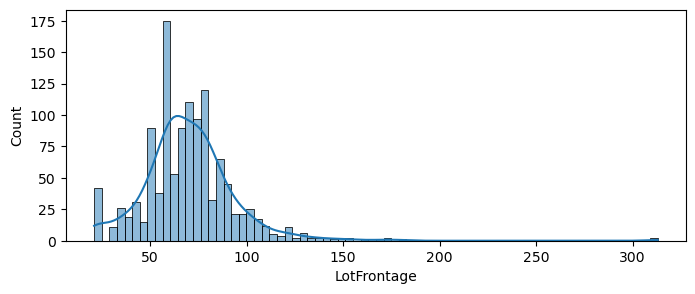

In [230]:
# Check the distribution of the LotFrontage (Linear feet of street connected to property) feature
from scipy.stats import skew
skewness = skew(df['LotFrontage'].dropna())
print(f"Skewness of LotFrontage: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['LotFrontage'].dropna(), kde=True)

Skewness of SalePrice: 1.88


<Axes: xlabel='SalePrice', ylabel='Count'>

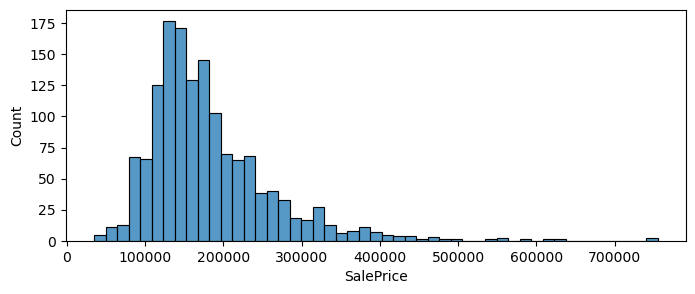

In [231]:
# Check additionaly the distribution of the target variable SalePrice
skewness = skew(df['SalePrice'])
print(f"Skewness of SalePrice: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['SalePrice'])

In [232]:
# The skewness of LotFrontage exceeds 2 which suggests substantial nonnormality. Imputing the mean looks not justified. 
# The skewness of the target feature is as well relatively high. Let's compare its median values for missing and present LotFrontage values to decide on the imputation strategy.

median_missing = df.loc[df['LotFrontage'].isna(), 'SalePrice'].median()
median_present = df.loc[df['LotFrontage'].notna(), 'SalePrice'].median()

print(f"Missing LotFrontage ({df['LotFrontage'].isna().shape[0]} rows): Median SalePrice: {median_missing:.2f}")
print(f"Present LotFrontage ({df['LotFrontage'].notna().shape[0]} rows): Median SalePrice: {median_present:.2f}")
print(f"Difference (Missing - Present): {median_missing - median_present:.2f}")

Missing LotFrontage (1460 rows): Median SalePrice: 172400.00
Present LotFrontage (1460 rows): Median SalePrice: 159500.00
Difference (Missing - Present): 12900.00


The 12900 median SalePrice difference suggests missingness is informative. Filling with the mean (or even median) of LotFrontage ignores this pattern and could bias the model by assuming missing values behave like present ones, which they don’t (higher median SalePrice).
To account for this factor let's introduce a new binary feature to flag missingness in addition to filling the original column with median values.

In [233]:
df['LotFrontage_missing'] = df['LotFrontage'].isna().astype(int)            # 1 if LotFrontage is missing, 0 otherwise
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())    # impute the median value

Let's now evaluate how the imputation of LotFrontage affected its correlation with SalePrice

In [234]:
# Correlation between LotFrontage (post-imputation) and SalePrice
correlation = df['LotFrontage'].corr(df['SalePrice'])
print(f"Correlation between LotFrontage (post-imputation) and SalePrice: {correlation:.3f}")

# For comparison, compute correlation pre-imputation (on non-missing data)
correlation_pre = df.loc[df['LotFrontage_missing'] == 0, 'LotFrontage'].corr(df.loc[df['LotFrontage_missing'] == 0, 'SalePrice'])
print(f"Correlation between LotFrontage (pre-imputation) and SalePrice: {correlation_pre:.3f}")

Correlation between LotFrontage (post-imputation) and SalePrice: 0.335
Correlation between LotFrontage (pre-imputation) and SalePrice: 0.352


Impact of Imputation:
- The drop from 0.352 to 0.335 is small (~4.8% relative decrease). This suggests that median imputation didn’t significantly distort the relationship between LotFrontage and SalePrice.
- However, even this slight decrease indicates that the imputation introduced a bit of noise. The 259 imputed values (17.7% of the data) are all set to the median, which reduces the variability in LotFrontage and slightly weakens its linear relationship with SalePrice.

- We can also try to implement regression imputation to predict missing LotFrontage values using other correlated with them features. 
- This might better preserve the relationship with SalePrice by imputing values that reflect patterns in the data.
- Then we will compare which approach turned to be more efficient.
- For this purpose let's first extract a few numerical features which show the strongest association with LotFrontage.

In [235]:
# Select numerical features and compute the correlation matrix
corr_matrix = df.select_dtypes(include='number').corr().round(3)

# Extract correlations involving LotFrontage and sort
lotfrontage_corrs = corr_matrix['LotFrontage'].sort_values()

# Filter correlations: keep only those < -0.3 or > 0.3
filtered_corrs = lotfrontage_corrs[(lotfrontage_corrs < -0.3) | (lotfrontage_corrs > 0.3)].drop('LotFrontage')

# Display the result
print("Correlations between LotFrontage and numerical features (<-0.3 or >0.3):")
print(filtered_corrs)

Correlations between LotFrontage and numerical features (<-0.3 or >0.3):
MSSubClass     -0.357
LotArea         0.305
TotRmsAbvGrd    0.321
GarageArea      0.324
SalePrice       0.335
TotalBsmtSF     0.363
GrLivArea       0.368
1stFlrSF        0.414
Name: LotFrontage, dtype: float64


In [236]:
# Select features for prediction
features = filtered_corrs.index.tolist()

# Split data
train_data = df[df['LotFrontage_missing'] == 0]
test_data = df[df['LotFrontage_missing'] == 1]

# Fit model
model = LinearRegression()
model.fit(train_data[features], train_data['LotFrontage'])

# Predict missing values. Assign the predicted values to the missing LotFrontage entries in the original DataFrame
df.loc[df['LotFrontage_missing'] == 1, 'LotFrontage'] = model.predict(test_data[features])

Now let's recheck the correlation to see if it improves

In [237]:
# Correlation between LotFrontage (post-imputation) and SalePrice
correlation = df['LotFrontage'].corr(df['SalePrice'])
print(f"Correlation between LotFrontage (post-imputation) and SalePrice: {correlation:.3f}")

# For comparison, compute correlation pre-imputation (on non-missing data)
correlation_pre = df.loc[df['LotFrontage_missing'] == 0, 'LotFrontage'].corr(
    df.loc[df['LotFrontage_missing'] == 0, 'SalePrice']
)
print(f"Correlation between LotFrontage (pre-imputation) and SalePrice: {correlation_pre:.3f}")

Correlation between LotFrontage (post-imputation) and SalePrice: 0.366
Correlation between LotFrontage (pre-imputation) and SalePrice: 0.352


- The correlation with SalePrice improved (regression imputation vs median imputation: 0.368 vs. 0.335), indicating that LotFrontage is now a stronger predictor of SalePrice.
- Unlike median imputation, which weakened the relationship, regression imputation strengthened it, suggesting that the imputed values are more representative of the true underlying LotFrontage values.

Now let's explore the second numeric variable win 8 NaNs: MasVnrArea (Masonry veneer area in square feet)

<Axes: xlabel='MasVnrArea', ylabel='Count'>

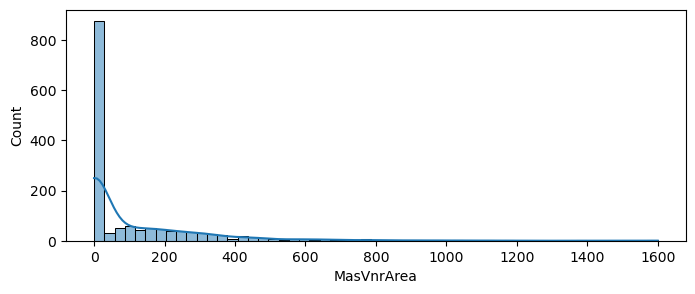

In [238]:
plt.figure(figsize=(8, 3))
sns.histplot(df['MasVnrArea'].dropna(), kde=True)

- There are a lot of zero values which correspond to absence of masonry veneer in certain houses. We just need to make sure that 8 missing values also belong to houses without masonry veneer.
- In the dataset there is a categorical feature MasVnrType which signifies which type of masonry veneer was used. 
- If in the corresponding rows there are no values, this would indicate that 8 missing values comply with the above-mentioned requirement.

In [239]:
df.loc[df['MasVnrArea'].isna(), 'MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [240]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())       # fill nulls with median which is equal 0
df['MasVnrArea'].isnull().sum()                                             # check if nulls are filled

# The 0 values in MasVnrArea are not missing values but rather indicate that there is no masonry veneer.
# In the dataset there is already the categorical feature MasVnrType where absent veneer is indicated by the value None.
# So we already have a feature indicating the absence of masonry veneer. No need to create new one based on null values in MasVnrArea.

0

Check the last numerical feature containing 81 NaNs: GarageYrBlt (Year garage was built)

<Axes: xlabel='GarageYrBlt', ylabel='Count'>

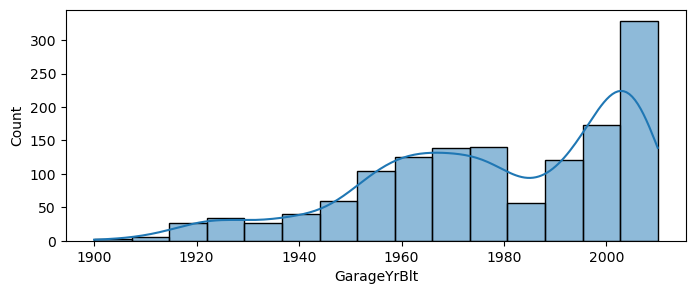

In [241]:
plt.figure(figsize=(8, 3))
sns.histplot(df['GarageYrBlt'].dropna(), kde=True)

In [242]:
# This feature has relatively hight number of NaNs and is likely to be strongly correlated with another feature (YearBuilt) which has no NaNs
# Let's check the correlation between GarageYrBlt and YearBuilt
corr = df.GarageYrBlt.corr(df["YearBuilt"])
print(f"Correlation between GarageYrBlt and YearBuilt: {corr:.3f}")

Correlation between GarageYrBlt and YearBuilt: 0.826


In [243]:
# The correlation is fairly strong -> danger of multicollinearity
# It seems justified to drop GarageYrBlt as YearBuilt must be enough to generally cover the relevant to the house age info
df = df.drop(['GarageYrBlt'], axis=1)

### Let's now deal with categorical features containing NaNs

In [244]:
cols_obj_with_nulls = [feature for feature in cols_with_nulls_names if feature != 'GarageYrBlt']    # list of object columns with nulls
df[cols_obj_with_nulls].select_dtypes(include=['object']).describe(include='all').round(2)          # describe features to better understand their quality and granularity

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
count,91,588,1423,1423,1422,1423,1422,1459,770,1379,1379,1379,1379,7,281,54
unique,2,3,4,4,4,6,6,5,5,6,3,5,5,3,4,4
top,Grvl,BrkFace,TA,TA,No,Unf,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
freq,50,445,649,1311,953,430,1256,1334,380,870,605,1311,1326,3,157,49


In [245]:
obj_with_nulls = df.select_dtypes(include=['object']).isnull().sum()    # count null values in remaining 'object' features
print(obj_with_nulls[obj_with_nulls > 0])                               # filter columns with null values

Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


### Alley

Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64


<Axes: xlabel='Alley', ylabel='SalePrice'>

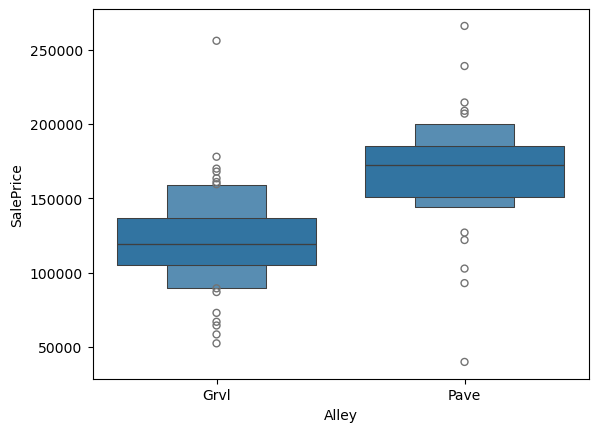

In [246]:
print(df['Alley'].value_counts(dropna=False))       # check the distribution of the Alley (Type of alley access to property: Gravel, Paved and None) feature
sns.boxenplot(x='Alley', y='SalePrice', data=df)    # check the distribution of SalePrice by Alley type

In [247]:
# The visually significant differences in SalePrice justify keeping all features and distinguishing between Grvl and Pave and NoAlley.
# Use target encoding with the median SalePrice. This preserves the signal from all three categories (NoAlley, Grvl, Pave) while handling the rare categories effectively
alley_medians = df.groupby('Alley')['SalePrice'].median()
df['Alley'] = df['Alley'].map(alley_medians)
print("Median SalePrice by Alley:")
print(alley_medians)

Median SalePrice by Alley:
Alley
Grvl    119500.0
Pave    172500.0
Name: SalePrice, dtype: float64


### MasVnrType

In [248]:
# Replace NaN with "None"
df['MasVnrType'] = df['MasVnrType'].fillna('None')
# Check the frequency distribution of the MasVnrType (Masonry veneer type: Brick Face, Stone, Cinder Block, None) feature
df['MasVnrType'].value_counts(dropna=False)       

MasVnrType
None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [ ]:
# Given the rare category BrkCmn (only 15 instances), target encoding (replacing each category with the median SalePrice for that category) seems like a good choice. 
# It handles rare categories well and keeps the feature as a single column.
masvnr_medians = df.groupby('MasVnrType')['SalePrice'].median()
df['MasVnrType'] = df['MasVnrType'].map(masvnr_medians)
print("Median SalePrice by MasVnrType:")
print(masvnr_medians)

Median SalePrice by MasVnrType:
MasVnrType
BrkCmn     139000.0
BrkFace    181000.0
None       143125.0
Stone      246839.0
Name: SalePrice, dtype: float64


### Bsmt... features:

- BsmtQual (Evaluates the height of the basement), 
- BsmtCond (Evaluates the general condition of the basement), 
- BsmtExposure (Refers to walkout or garden level walls), 
- BsmtFinType1 (Rating of basement finished area), 
- BsmtFinType2 (Rating of basement finished area (if multiple types))

In [36]:
# List of categorical basement features
bsmt_categorical_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

# List of numeric basement features
bsmt_numeric_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

# Dictionary to store results
results = {}

# Loop through each categorical feature
for feature in bsmt_categorical_features:
    # Group by the categorical feature and calculate the mean of numeric features
    # Use dropna=False to include NA as a category
    group_means = df.groupby(feature, dropna=False)[bsmt_numeric_features].mean()
    # Store the result in the dictionary
    results[feature] = group_means

# Display the results for each categorical feature
for feature, means in results.items():
    print(f"\nMean of numeric features grouped by {feature}:")
    print(means.round(2))
    print("-" * 50)


Mean of numeric features grouped by BsmtQual:
          BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF
BsmtQual                                                
Ex            855.33       23.56     766.71      1645.60
Fa            130.71        7.89     594.43       733.03
Gd            472.50       34.66     623.91      1131.07
TA            381.57       66.90     506.96       955.43
NaN             0.00        0.00       0.00         0.00
--------------------------------------------------

Mean of numeric features grouped by BsmtCond:
          BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF
BsmtCond                                                
Fa            217.76       13.07     640.91       871.73
Gd            450.37      104.77     579.02      1134.15
Po            175.00        0.00     647.00       822.00
TA            463.99       46.20     580.02      1090.20
NaN             0.00        0.00       0.00         0.00
--------------------------------------------------

Mean 


---

## **2. Exploratory Data Analysis (EDA)**

### Question 3: Describe the dataset's numerical features.
- Use `describe()` to get a summary of the dataset's numerical columns.
- Which feature(s) have the highest and lowest values? Are there any surprising observations?

### Question 4: Visualize the distribution of house prices.
- Create a histogram of the house prices. Is the distribution normal or skewed?

### Question 5: Explore relationships between features and house prices.
- Create scatter plots for at least 3 features vs. house prices (target variable).
- What relationships do you observe between the selected features and the target?

---

## **3. Feature Selection**

### Question 6: Correlation Analysis
- Calculate the correlation matrix of the dataset.
- Based on the correlation, identify at least 2 features that are highly correlated with house prices.
- Are there any features that are strongly correlated with each other but not with the target?

---

## **4. Regression Modeling**

### Question 7: Split the dataset
- Split the dataset into training and testing sets. Use an 80/20 split.
- Make sure to separate the target variable (house prices) from the features.

### Question 8: Train a Linear Regression Model
- Train a Linear Regression model using the training data.
- Evaluate the model's performance on the test data by calculating the Mean Squared Error (MSE).

### Question 9: Feature Importance (Optional)
- If using a model like Ridge or Lasso, identify which features are most important in predicting house prices.

---

## **5. Conclusion**
- Summarize your findings and observations.
- Reflect on the regression model's performance and whether there are any improvements you would recommend.